<a href="https://colab.research.google.com/github/QColeman97/AudioTagger/blob/master/AudioTagger_AlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Freesound Dataset Kaggle 2018 Solution

This is private 0.917 / public 0.950 solution.

In [0]:
#!unzip results.zip

In [64]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import warnings

import numpy as np
import sys, shutil
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from pathlib import Path
import IPython

from tqdm import tqdm_notebook
import librosa

import os

In [0]:
# Dataset preparation

EXTRA = Path('fsd2018_extra')

# Data frames for train/test dataset
INPUT_PATH ="drive/My Drive/CSC490Final-AudioTagger/"

audio_train_file = (INPUT_PATH + "FSDKaggle2018.audio_train")
audio_test_file = (INPUT_PATH + "FSDKaggle2018.audio_test")
df_train = pd.read_csv(INPUT_PATH + "train_post_competition.csv")
df_test = pd.read_csv(INPUT_PATH + 'test_post_competition_scoring_clips.csv')


# Labels and integer converter
labels = df_train.label.unique()
label2int = {l:i for i, l in enumerate(labels)}
num_classes = len(labels)

# Train data sample index of manually verified ones
train_verified_idx = np.array(df_train[df_train.manually_verified == 1].index)
# Plain y_train label
plain_y_train = np.array([label2int[label] for label in df_train.label])

In [0]:
## External dependencies - mixup & random eraser
#
# Downloaded from https://github.com/yu4u/mixup-generator
#

import numpy as np


class MixupGenerator():
    def __init__(self, X_train, y_train, batch_size=32, alpha=0.2, shuffle=True, datagen=None):
        self.X_train = X_train
        self.y_train = y_train
        self.batch_size = batch_size
        self.alpha = alpha
        self.shuffle = shuffle
        self.sample_num = len(X_train)
        self.datagen = datagen

    def __call__(self):
        while True:
            indexes = self.__get_exploration_order()
            itr_num = int(len(indexes) // (self.batch_size * 2))

            for i in range(itr_num):
                batch_ids = indexes[i * self.batch_size * 2:(i + 1) * self.batch_size * 2]
                X, y = self.__data_generation(batch_ids)

                yield X, y

    def __get_exploration_order(self):
        indexes = np.arange(self.sample_num)

        if self.shuffle:
            np.random.shuffle(indexes)

        return indexes

    def __data_generation(self, batch_ids):
        _, h, w, c = self.X_train.shape
        l = np.random.beta(self.alpha, self.alpha, self.batch_size)
        X_l = l.reshape(self.batch_size, 1, 1, 1)
        y_l = l.reshape(self.batch_size, 1)

        X1 = self.X_train[batch_ids[:self.batch_size]]
        X2 = self.X_train[batch_ids[self.batch_size:]]
        X = X1 * X_l + X2 * (1 - X_l)

        if self.datagen:
            for i in range(self.batch_size):
                X[i] = self.datagen.random_transform(X[i])
                X[i] = self.datagen.standardize(X[i])

        if isinstance(self.y_train, list):
            y = []

            for y_train_ in self.y_train:
                y1 = y_train_[batch_ids[:self.batch_size]]
                y2 = y_train_[batch_ids[self.batch_size:]]
                y.append(y1 * y_l + y2 * (1 - y_l))
        else:
            y1 = self.y_train[batch_ids[:self.batch_size]]
            y2 = self.y_train[batch_ids[self.batch_size:]]
            y = y1 * y_l + y2 * (1 - y_l)

        return X, y


def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255):
    def eraser(input_img):
        img_h, img_w, _ = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        c = np.random.uniform(v_l, v_h)
        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

## Strategy

This solution has two different approaches, and overall result is the ensemble of both results.

- Approach LH: Uses highest feature resolution, but only with beginning part of sounds.
- Approach X: Splits samples and uses all the samples long enough, but with coarser feature resolution.

Motivation to have these two is based on observation of how models performs well and fails.

- Useful information seems to be around the beginning part of sample. This should be natural considering how we record and edit target sound. This assumption was supported by good results of approach LH which uses only the beginning some sconds.
- But it fails with such samples that has important content in the middle or later part. To save these cases, we need another approach that uses entire sample wave. This is approach X.

Here starting with making configuration variables for these approaches.

In [0]:
confX = {}
confs = [confX]
confX['folder'] = Path('X')

## Preprocess and Convert Data

All the train and test data are converted in advance, so that we can simply load it when training.

We have bunch of audio parameters here which performance of models fairly depends on.

In [0]:
# Approach X uses longer sound, then it uses suppressed 
confX['sampling_rate'] = 26000
confX['duration'] = 6
confX['hop_length'] = 520 # 20ms
confX['fmin'] = 20
confX['fmax'] = confX['sampling_rate'] // 2
confX['n_mels'] = 48
confX['n_fft'] = confX['n_mels'] * 20
confX['audio_split'] = 'dont_crop'

# Auto calculate other configuration paramters

def auto_complete_conf(conf):
    conf['samples'] = conf['sampling_rate'] * conf['duration']
    conf['dims'] = (conf['n_mels'], 1 + int(np.floor(conf['samples']/conf['hop_length'])), 1)


auto_complete_conf(confX)

### Preprocessing functions

- read_audio: Trims silence of both ends, then split if longer or pad if shorter.
- audio_to_melspectrogram: Convert audio samples into mel-spectrogram data.
- read_as_melspectrogram: Do both above.

In [0]:
import librosa
import librosa.display

def read_audio(conf, pathname):
    y, sr = librosa.load(pathname, sr=conf['sampling_rate'])
    # trim silence
    if 0 < len(y): # workaround: 0 length causes error
        y, _ = librosa.effects.trim(y) # trim, top_db=default(60)
    # make it unified length to conf.samples
    if len(y) > conf['samples']: # long enough
        if conf['audio_split'] == 'head':
            y = y[0:0+conf['samples']]
    else: # pad blank
        padding = conf['samples'] - len(y)    # add padding at both ends
        offset = padding // 2
        y = np.pad(y, (offset, conf['samples'] - len(y) - offset), 'constant')
    return y

def audio_to_melspectrogram(conf, audio):
    spectrogram = librosa.feature.melspectrogram(audio, 
                                                 sr=conf['sampling_rate'],
                                                 n_mels=conf['n_mels'],
                                                 hop_length=conf['hop_length'],
                                                 n_fft=conf['n_fft'],
                                                 fmin=conf['fmin'],
                                                 fmax=conf['fmax'])
    spectrogram = librosa.power_to_db(spectrogram)
    spectrogram = spectrogram.astype(np.float32)
    return spectrogram

def show_melspectrogram(mels, conf):
    librosa.display.specshow(mels, x_axis='time', y_axis='mel', 
                             sr=conf['sampling_rate'], hop_length=conf['hop_length'],
                            fmin=conf['fmin'], fmax=conf['fmax'])
    plt.colorbar(format='%+2.0f dB')
    plt.title('Log-frequency power spectrogram')
    plt.show()

def read_as_melspectrogram(conf, pathname, debug_display=False):
    x = read_audio(conf, pathname)
    mels = audio_to_melspectrogram(conf, x)
    if debug_display:
        IPython.display.display(IPython.display.Audio(x, rate=conf['sampling_rate']))
        show_melspectrogram(mels, conf)
    return mels

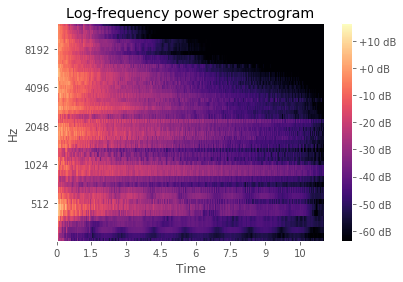

In [71]:
# Preprocessing examples

_ = read_as_melspectrogram(confX, audio_train_file+ '/' + df_train.fname[0], debug_display=True)

LH has fine-grained features for 4 seconds, and  X has more abstract whole sample (for now).

### Converter

In [0]:
def split_long_data(conf, X):
    # Splits long mel-spectrogram data with small overlap
    L = X.shape[1]
    one_length = conf['dims'][1]
    loop_length = int(one_length * 0.9)
    min_length = int(one_length * 0.2)
    print(' sample length', L, 'to cut every', one_length)
    for idx in range(L // loop_length):
        cur = loop_length * idx
        rest = L - cur
        if one_length <= rest:
            yield X[:, cur:cur+one_length]
        elif min_length <= rest:
            cur = L - one_length
            yield X[:, cur:cur+one_length]

def convert_X(df, conf, datapath):
    # Convert all files listed on df.fname
    # Then generates X (contains mel-spectrograms)
    # and index mapping to original sample order
    X = []
    index_map = []
    for i, fname in enumerate(df.fname):
        print('processing', fname)
        data = read_as_melspectrogram(conf, datapath + '/' + fname)
        for chunk in split_long_data(conf, data):
            X.append(np.expand_dims(chunk, axis=-1))
            index_map.append(i)
    return np.array(X), np.array(index_map)

def convert_y_train(idx_train, plain_y_train):
    return np.array( [plain_y_train[idx] for idx in idx_train])

In [73]:
# Example - process up to 10 samples
print('All samples will be cut per split length (=duration)')
X_train, idx_train = convert_X(df_train[:10], confX, audio_train_file)
y_train = convert_y_train(idx_train, plain_y_train)
print('Now original 10 samples were cut into ', len(idx_train), 'samples.')
print()
print('idx_train holds original sample index, y_train is also converted to have the same length with X_train/idx_train.')
print('idx_train', idx_train)
print('y_train', y_train)

All samples will be cut per split length (=duration)
processing 00044347.wav
 sample length 578 to cut every 301
processing 001ca53d.wav
 sample length 517 to cut every 301
processing 002d256b.wav
 sample length 301 to cut every 301
processing 0033e230.wav
 sample length 301 to cut every 301
processing 00353774.wav
 sample length 301 to cut every 301
processing 003b91e8.wav
 sample length 665 to cut every 301
processing 003da8e5.wav
 sample length 301 to cut every 301
processing 0048fd00.wav
 sample length 301 to cut every 301
processing 004ad66f.wav
 sample length 351 to cut every 301
processing 0063ab88.wav
 sample length 1483 to cut every 301
Now original 10 samples were cut into  16 samples.

idx_train holds original sample index, y_train is also converted to have the same length with X_train/idx_train.
idx_train [0 0 1 2 3 4 5 5 6 7 8 9 9 9 9 9]
y_train [0 0 1 2 3 4 4 4 5 6 7 8 8 8 8 8]


## Create Dataset Files

Now convert all the data and store them on files.

Toy example dataset which is subset of whole samples will be prepared by default, for running on Kaggle kernel.

In [0]:
# Data utilities
def datapath(conf, filename):
    return conf['folder'] / filename

def loaddata(conf, filename):
    return np.load(conf['folder'] / filename)

#### This is Toy example by default ####
TRYING_AS_TOY = True # False if you like creating full set

for conf in confs:
    conf['folder'].mkdir(parents=True, exist_ok=True)
    if TRYING_AS_TOY:
        for file in ['X_train', 'y_train', 'idx_train', 'X_test', 'idx_test']:
            shutil.copy(EXTRA/datapath(conf, file+'.npy'), datapath(conf, file+'.npy'))
        plain_y_train = np.load(EXTRA/'toy_plain_y_train.npy')
        train_verified_idx = np.load(EXTRA/'toy_train_verified_idx.npy')
        train_blacklist_index = np.load(EXTRA / 'toy_train_blacklist.npy')
    else:
        if not os.path.exists(datapath(conf, 'X_train.npy')):
            X_train, idx_train = convert_X(df_train, conf, DATAROOT / 'audio_train')
            y_train = convert_y_train(idx_train, plain_y_train)
            np.save(datapath(conf, 'X_train.npy'), X_train)
            np.save(datapath(conf, 'y_train.npy'), y_train)
            np.save(datapath(conf, 'idx_train.npy'), idx_train)

            X_test, idx_test = convert_X(df_test, conf, DATAROOT / 'audio_test')
            np.save(datapath(conf, 'X_test.npy'), X_test)
            np.save(datapath(conf, 'idx_test.npy'), idx_test)

## Models

SEResNet was basically used for competition submission. Here AlexNet based model is enabled by default for Kaggle kernel.

In [0]:
import keras
from keras.layers import Dense, Conv2D, AveragePooling2D
from keras.layers import MaxPooling2D, GlobalAveragePooling2D, Dropout, BatchNormalization, Flatten
from keras.models import Model, Sequential

def create_model(conf, num_classes):
    input_shape = conf['dims']
    if False:
        # This is the model used for competition
        # Thanks to: https://github.com/titu1994/keras-squeeze-excite-network
        from se_resnet import SEResNet
        model = SEResNet(input_shape=input_shape,
               width=1,
               bottleneck=True,
               weight_decay=1e-4,
               include_top=True,
               depth=[3, 4, 4, 3],
               filters=[32, 64, 128, 256],
               weights=None,
               input_tensor=None,
               pooling=None,
               classes=num_classes)
    elif False: # Or if you prefer VGG16
        from keras.applications.vgg16 import VGG16
        # create new empty model with desired input_shape
        base_model = VGG16(weights=None, input_shape=input_shape, include_top=False)
        # you can also set this as: weights='imagenet' if you want transfer learning from imagenet
        x = GlobalAveragePooling2D()(base_model.output)
        x = Dense(1024, activation='relu')(x)
        predictions = Dense(num_classes, activation='softmax')(x)
        model = Model(inputs=base_model.input, outputs=predictions)
    else: # AlexNet based model
        model = Sequential()
        model.add(Conv2D(48, 11,  input_shape=input_shape, strides=(2,3), activation='relu', padding='same'))
        model.add(MaxPooling2D(3, strides=(1,2)))
        model.add(BatchNormalization())
        model.add(Conv2D(128, 5, strides=(2,3), activation='relu', padding='same'))
        model.add(MaxPooling2D(3, strides=2))
        model.add(BatchNormalization())
        model.add(Conv2D(192, 3, strides=(1, 2), activation='relu', padding='same'))
        model.add(Conv2D(192, 3, strides=(1, 1), activation='relu', padding='same'))
        model.add(Conv2D(128, 3, strides=(1, 1), activation='relu', padding='same'))
        model.add(MaxPooling2D(3, strides=(1,2)))
        model.add(BatchNormalization())
        model.add(Flatten())
        model.add(Dense(256, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(256, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(lr=conf['learning_rate']),
              metrics=['accuracy'])
    model.summary()
    return model

## Training

Datasets and model are ready, now prepare for training.



### Utilities for Balancing Category Distribution

In [0]:
def get_class_distribution(y):
    # y_cls can be one of [OH label, index of class, class label name]
    # convert OH to index of class
    y_cls = [np.argmax(one) for one in y] if len(np.array(y).shape) == 2 else y
    # y_cls can be one of [index of class, class label name]
    classset = sorted(list(set(y_cls)))
    sample_distribution = {cur_cls:len([one for one in y_cls if one == cur_cls]) for cur_cls in classset}
    return sample_distribution

def get_class_distribution_list(y, num_classes):
    dist = get_class_distribution(y)
    assert(y[0].__class__ != str) # class index or class OH label only
    list_dist = np.zeros((num_classes))
    for i in range(num_classes):
        if i in dist:
            list_dist[i] = dist[i]
    return list_dist

from imblearn.over_sampling import RandomOverSampler
def balance_class_by_over_sampling(X, y):
    Xidx = [[xidx] for xidx in range(len(X))]
    y_cls = [np.argmax(one) for one in y]
    classset = sorted(list(set(y_cls)))
    sample_distribution = [len([one for one in y_cls if one == cur_cls]) for cur_cls in classset]
    nsamples = np.max(sample_distribution)
    flat_ratio = {cls:nsamples for cls in classset}
    Xidx_resampled, y_cls_resampled = RandomOverSampler(ratio=flat_ratio, random_state=42).fit_sample(Xidx, y_cls)
    sampled_index = [idx[0] for idx in Xidx_resampled]
    return np.array([X[idx] for idx in sampled_index]), np.array([y[idx] for idx in sampled_index])

def visualize_class_balance(title, y, labels):
    sample_dist_list = get_class_distribution_list(y, len(labels))
    index = range(len(labels))
    fig, ax = plt.subplots(1, 1, figsize = (16, 5))
    ax.bar(index, sample_dist_list)
    ax.set_xlabel('Label')
    ax.set_xticks(index)
    ax.set_xticklabels(labels, rotation='vertical')
    ax.set_ylabel('Number of Samples')
    ax.set_title(title)
    fig.show()

def print_class_balance(title, y, labels):
    distributions = get_class_distribution(y)
    dist_dic = {labels[cls]:distributions[cls] for cls in distributions}
    print(title, '=', dist_dic)
    zeroclasses = [label for i, label in enumerate(labels) if i not in distributions.keys()]
    if 0 < len(zeroclasses):
        print(' 0 sample classes:', zeroclasses)

### Dataset related Utilities

All the augmentatoion is done by data generators.

In [0]:
from keras.preprocessing.image import ImageDataGenerator

def create_generators(conf, _Xtrain, _ytrain, _Xvalid, _yvalid):
    # Create Keras ImageDataGenerator
    aug_datagen = ImageDataGenerator(
        featurewise_center=conf['normalize'] == 'featurewise',
        featurewise_std_normalization=conf['normalize'] == 'featurewise',
        rotation_range=0,
        width_shift_range=0.4,
        height_shift_range=0.0,
        horizontal_flip=True,
        preprocessing_function=get_random_eraser(v_l=-1, v_h=1)
    )
    plain_datagen = ImageDataGenerator(
        featurewise_center=aug_datagen.featurewise_center,
        featurewise_std_normalization=aug_datagen.featurewise_std_normalization,
    )
    # Set featurewise normalization mean/std
    if aug_datagen.featurewise_center:
        print(' normalize featurewise')
        aug_datagen.mean, aug_datagen.std = np.mean(_Xtrain), np.std(_Xtrain)
        plain_datagen.mean, plain_datagen.std = aug_datagen.mean, aug_datagen.std
    # Create Generators
    train_generator = MixupGenerator(_Xtrain, _ytrain, 
                                     alpha=1.0, batch_size=conf['batch_size'], datagen=aug_datagen)()
    valid_generator = plain_datagen.flow(_Xvalid, _yvalid,
                                         batch_size=conf['batch_size'], shuffle=False)
    return train_generator, valid_generator, plain_datagen

def get_steps_per_epoch(conf, _Xtrain, _Xvalid):
    train_steps_per_epoch = len(_Xtrain) // conf['batch_size']
    valid_steps_per_epoch = len(_Xvalid) // conf['batch_size']
    return train_steps_per_epoch, valid_steps_per_epoch

def samplewise_mean_X(X):
    for i in range(len(X)):
        X[i] -= np.mean(X[i], keepdims=True)
        X[i] /= (np.std(X[i], keepdims=True) + 1.0) # Kind of Compressor effect

### Fold Generator & Trainer

In [0]:
from sklearn.model_selection import train_test_split
def get_cross_valid_fold_balanced(conf, fold, X_train, y_train, idx_train):
    indices = np.array(range(len(X_train)))
    # Cross validation split -> _Xtrain|_ytrain, _Xvalid|_yvalid
    _, _, _, _, train_fold, valid_fold = train_test_split(X_train, y_train, indices,
                                                          test_size=conf['test_size'],
                                                          random_state=conf['random_state'] + fold*10)
    _Xtrain, _ytrain = X_train[train_fold], y_train[train_fold]

    # Validation set to filter non-verified samples if requested
    if conf['valid_limit'] == 'manually_verified_only':
        filtered = [idx for idx in valid_fold if idx_train[idx] in train_verified_idx]
        print(' valid set is filtered to verified samples only, %d -> %d' % (len(valid_fold), len(filtered)))
        valid_fold = filtered
    _Xvalid, _yvalid = X_train[valid_fold], y_train[valid_fold]

    # Balance distribution -> _Xtrain|_ytrain (overwritten)
    print_class_balance('Current fold category distribution', _ytrain, labels)
    _Xtrain, _ytrain = balance_class_by_over_sampling(_Xtrain, _ytrain)
    print_class_balance('after balanced', _ytrain, labels)

    return _Xtrain, _ytrain, _Xvalid, _yvalid

from keras.callbacks import (EarlyStopping, LearningRateScheduler,
                             ModelCheckpoint, TensorBoard, ReduceLROnPlateau)
from keras import backend as K
def train_model(conf, fold, model, train_generator, valid_generator,
                train_steps_per_epoch, valid_steps_per_epoch,
                init_best_weights=False, this_epochs=None):
    callbacks = [
        ModelCheckpoint(str(datapath(conf, 'best_%d.h5' % fold)),
                        monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True),
        TensorBoard(log_dir=str(datapath(conf, 'logs%s/fold_%d' % (conf['folder'], fold))), write_graph=True)
    ]
    # Create model
    if model is None:
        model = create_model(conf, num_classes)
        #if fold == 0:
        #    model.summary()
        # Load weights
        weight_filename = str(init_best_weights) # for when file name was set
        if weight_filename == 'True': weight_filename = str(datapath(conf, 'best_%d.h5' % fold))
        if weight_filename is not 'False':
            print(' Initializing model with last best weights:', weight_filename)
            model.load_weights(weight_filename)
    # Train model
    history = model.fit_generator(train_generator,
                    steps_per_epoch=train_steps_per_epoch,
                    epochs=conf['epochs'] if this_epochs is None else this_epochs,
                    validation_data=valid_generator, 
                    validation_steps=valid_steps_per_epoch,
                    callbacks=callbacks,
                    verbose=conf['verbose'])
    return model, history

### More training utilities

In [0]:
def geometric_mean_preds(_preds):
    preds = _preds.copy()
    for i in range(1, preds.shape[0]):
        preds[0] = np.multiply(preds[0], preds[i])
    return preds[0]

def get_unified_preds(preds, pred_idx, N):
    mean_results = []
    for idx in range(N):
        this_preds = preds[np.where(pred_idx == idx)]
        if len(this_preds) <= 0:
            print(' no result: %d' % idx)
            mean_results.append(np.ones((preds.shape[1],)))
        else:
            mean_results.append(geometric_mean_preds(this_preds))
    return np.array(mean_results)

def evaluate_pred_acc(y, uni_preds, idx_map, N):
    uni_y = []
    for idx in range(N):
        uni_y.append(y[np.where(idx_map == idx)[0]][0])
    uni_y = np.array(uni_y)

    refs = np.argmax(uni_y, axis=1)
    results = np.argmax(uni_preds, axis=1)
    acc = np.sum(refs == results) / len(refs)
    n_verified = len(refs[train_verified_idx])
    acc_verified = np.sum(refs[train_verified_idx] == results[train_verified_idx]) / n_verified
    return acc, acc_verified

def evaluate_fold(conf, fold, filenametmpl, model, plain_datagen, X, idx_map, y=None, verified_idx=None):
    # predict
    _y = keras.utils.to_categorical(np.ones((len(X)))) if y is None else y
    test_generator = plain_datagen.flow(X, _y, batch_size=conf['batch_size'], shuffle=False)
    preds = model.predict_generator(test_generator, steps = len(test_generator))
    preds = get_unified_preds(preds, idx_map, np.max(idx_map) + 1)
    # save & return acc
    np.save(datapath(conf, filenametmpl % fold), preds)
    # evaluate 
    if y is not None:
        return evaluate_pred_acc(y, preds, idx_map, len(plain_y_train))
    return None, None

def run_fold(conf, fold, dataset, model=None, init_best_weights=False, eval_only=False):
    X_train, y_train, idx_train, all_X_train, all_y_train, all_idx_train, X_test, idx_test = dataset
    print('----- Fold#%d ----' % fold)
    # c. Cross validation split & balance # of samples
    _Xtrain, _ytrain, _Xvalid, _yvalid = \
        get_cross_valid_fold_balanced(conf, fold, X_train, y_train, idx_train)

    # d. Train model
    train_generator, valid_generator, plain_datagen = \
        create_generators(conf, _Xtrain, _ytrain, _Xvalid, _yvalid)
    train_steps_per_epoch, valid_steps_per_epoch = \
        get_steps_per_epoch(conf, _Xtrain, _Xvalid)
    model, history = train_model(conf, fold, model, train_generator, valid_generator,
                                train_steps_per_epoch, valid_steps_per_epoch,
                                 init_best_weights=init_best_weights,
                                this_epochs=0 if eval_only else None)

    # e. Evaluate with all train sample
    model.load_weights(datapath(conf, 'best_%d.h5' % fold))
    acc, acc_v = evaluate_fold(conf, fold, 'train_predictions_%d.npy', model, plain_datagen,
                               all_X_train, all_idx_train, all_y_train, train_verified_idx)
    evaluate_fold(conf, fold, 'test_predictions_%d.npy', model, plain_datagen, X_test, idx_test)

    print('Trainset accuracy =', acc, '(tested all over the original training set)')
    print('Verified samples accuracy =', acc_v, '(tested over manually verified samples only)')
    return acc, acc_v, history, model, plain_datagen

### Training Parameters

In [0]:
confLH['n_fold'] = 2 if TRYING_AS_TOY else 5
confLH['normalize'] = 'samplewise'
confLH['valid_limit'] = 'manually_verified_only'
confLH['random_state'] = 42
confLH['test_size'] = 0.2
confLH['batch_size'] = 32
confLH['learning_rate'] = 0.0001
confLH['epochs'] = 10 if TRYING_AS_TOY else 200
confLH['verbose'] = 1

confX['n_fold'] = 2 if TRYING_AS_TOY else 5
confX['normalize'] = 'featurewise'
confX['valid_limit'] = None
confX['random_state'] = 42
confX['test_size'] = 0.2
confX['batch_size'] = 32
confX['learning_rate'] = 0.0001
confX['epochs'] = 10 if TRYING_AS_TOY else 200
confX['verbose'] = 1

### Now let's begin

Training will do followings.

- a. Load all dataset -> all_(X|y|idx)_train, (X|idx)_test
- b. Removing samples on the blacklist -> X|y|idx
- c. Cross validation split & balance # of samples
- d. Train model with data (augmentation) generators
- e. Evaluate with all train sample

In [81]:
for conf in [confX]: # Running confX only, change this to confs if you need running both confX and confLH
    print('== Attempt [%s] ==' % conf['folder'])

    # a. Load all dataset -> all_(X|y|idx)_train, (X|idx)_test
    all_X_train, all_y_train, all_idx_train = \
        loaddata(conf, 'X_train.npy'), \
        keras.utils.to_categorical(loaddata(conf, 'y_train.npy')), \
        loaddata(conf, 'idx_train.npy')
    X_test, idx_test = loaddata(conf, 'X_test.npy'), loaddata(conf, 'idx_test.npy')
    print('Loaded trainset:%d, testset:%d samples.' % (len(all_X_train), len(X_test)))

    # a'. Normalize samplewise if requested
    if conf['normalize'] == 'samplewise':
        print(' normalize samplewise')
        samplewise_mean_X(all_X_train)
        samplewise_mean_X(X_test)

    # b. Removing samples on the blacklist -> X|y|idx
    whitelist = [idx for idx in range(len(all_idx_train)) if all_idx_train[idx] not in train_blacklist_index]
    X_train, y_train, idx_train = \
        all_X_train[whitelist], all_y_train[whitelist], all_idx_train[whitelist]
    print('Filtered samples on blacklist, now trainset has %d samples' % len(idx_train))

    # Train folds
    work = {'train_acc': [],
            'train_acc_verified': [],
            'history': []}
    for fold in range(conf['n_fold']):
        acc, acc_verified, history, model, _ = run_fold(conf, fold,
                [X_train, y_train, idx_train, all_X_train, all_y_train, all_idx_train, X_test, idx_test],
                model=None,
                init_best_weights=EXTRA / 'X48_AlexNet_00696.h5',
                eval_only=False)
        work['history'].append(history)
        work['train_acc'].append(acc)
        work['train_acc_verified'].append(acc_verified)

    print('___ training finished ___')

== Attempt [X] ==
Loaded trainset:431, testset:337 samples.
Filtered samples on blacklist, now trainset has 429 samples
----- Fold#0 ----
Current fold category distribution = {'Hi-hat': 6, 'Saxophone': 8, 'Trumpet': 9, 'Glockenspiel': 4, 'Cello': 9, 'Knock': 6, 'Gunshot_or_gunfire': 6, 'Clarinet': 8, 'Computer_keyboard': 5, 'Keys_jangling': 7, 'Snare_drum': 8, 'Writing': 11, 'Laughter': 8, 'Tearing': 9, 'Fart': 7, 'Oboe': 6, 'Flute': 13, 'Cough': 11, 'Telephone': 6, 'Bark': 12, 'Chime': 7, 'Bass_drum': 8, 'Bus': 1, 'Squeak': 15, 'Scissors': 1, 'Harmonica': 5, 'Gong': 13, 'Microwave_oven': 12, 'Burping_or_eructation': 3, 'Double_bass': 7, 'Shatter': 11, 'Fireworks': 18, 'Tambourine': 3, 'Cowbell': 4, 'Electric_piano': 10, 'Meow': 8, 'Drawer_open_or_close': 8, 'Applause': 19, 'Acoustic_guitar': 19, 'Violin_or_fiddle': 6, 'Finger_snapping': 6}
after balanced = {'Hi-hat': 19, 'Saxophone': 19, 'Trumpet': 19, 'Glockenspiel': 19, 'Cello': 19, 'Knock': 19, 'Gunshot_or_gunfire': 19, 'Clarinet':

## Ensemble

In [0]:
def pred_geometric_mean(preds_set):
    predictions = np.ones_like(preds_set[0])
    for preds in preds_set:
        predictions = predictions*preds
    predictions = predictions**(1./len(preds_set))
    return predictions

def pred_geometric_mean_by_files(npy_pred_files):
    preds_set = np.array([np.load(file) for file in npy_pred_files])
    predictions = pred_geometric_mean(preds_set)
    return predictions

In [83]:
for conf in [confX]: # Running confX only, change this to confs if you need running both confX and confLH
    print('== Attempt [%s] ==' % conf['folder'])
    train_pred_files = list(conf['folder'].glob('train_pred*.npy'))
    print('Train set ensemble = ', train_pred_files)
    ensembled_train_preds = pred_geometric_mean_by_files(train_pred_files)
    y_train = keras.utils.to_categorical(loaddata(conf, 'y_train.npy'))
    acc, acc_v = evaluate_pred_acc(y_train, ensembled_train_preds, all_idx_train, len(plain_y_train))
    print('Ensemble train set accuracy =', acc)
    print('Ensemble verified samples accuracy =', acc_v)
    np.save(datapath(conf, 'ensemble_train_preds.npy'), ensembled_train_preds)

    test_pred_files = list(conf['folder'].glob('test_pred*.npy'))
    print('Test set ensemble = ', test_pred_files)
    ensembled_test_preds = pred_geometric_mean_by_files(test_pred_files)
    np.save(datapath(conf, 'ensemble_test_preds.npy'), ensembled_test_preds)

== Attempt [X] ==
Train set ensemble =  [PosixPath('X/train_predictions_0.npy'), PosixPath('X/train_predictions_1.npy')]
Ensemble train set accuracy = 0.8526315789473684
Ensemble verified samples accuracy = 0.9629629629629629
Test set ensemble =  [PosixPath('X/test_predictions_0.npy'), PosixPath('X/test_predictions_1.npy')]
